### Bitcoin price prediction using Recurrent Neural Networks

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import sqrt
from numpy import concatenate
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [7]:
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', api_key='BgqUqWzR-yx62hjaxBho',returns='pandas')

In [8]:
data.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2300 entries, 2014-01-07 to 2020-04-24
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               2300 non-null   float64
 1   High               2300 non-null   float64
 2   Low                2300 non-null   float64
 3   Close              2300 non-null   float64
 4   Volume (BTC)       2300 non-null   float64
 5   Volume (Currency)  2300 non-null   float64
 6   Weighted Price     2300 non-null   float64
dtypes: float64(7)
memory usage: 143.8 KB


In [10]:
data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2020-04-20,7125.8,7224.0,6760.2,6839.2,7408.890870,5.165698e+07,6972.295690
2020-04-21,6838.2,6952.6,6773.1,6852.1,4638.378962,3.183838e+07,6864.117446
2020-04-22,6855.0,7165.0,6819.8,7136.9,5933.870005,4.171225e+07,7029.518686
2020-04-23,7136.8,7790.0,7035.2,7485.0,11413.461623,8.461851e+07,7413.922042
2020-04-24,7489.8,7610.0,7370.0,7500.0,7336.387144,5.514200e+07,7516.234317


Data is latest until 20.04.2020 as of this project.
#### Plotting line graph based on Weighted Price

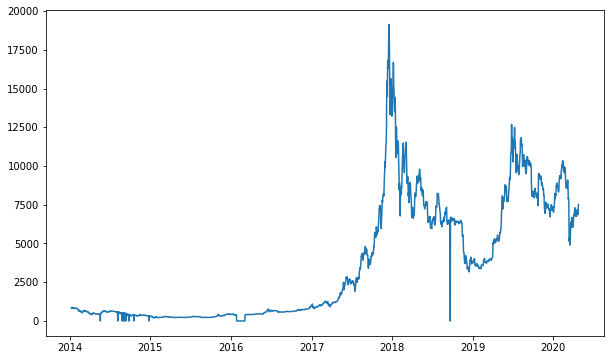

In [19]:
plt.figure(figsize=(10,6))
plt.plot(data['Weighted Price'])
plt.show()

In [20]:
#Let's fill missing values using ffill (forward fill) method that fills missing values with last propogated value.
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)
data.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume (BTC)         0
Volume (Currency)    0
Weighted Price       0
dtype: int64

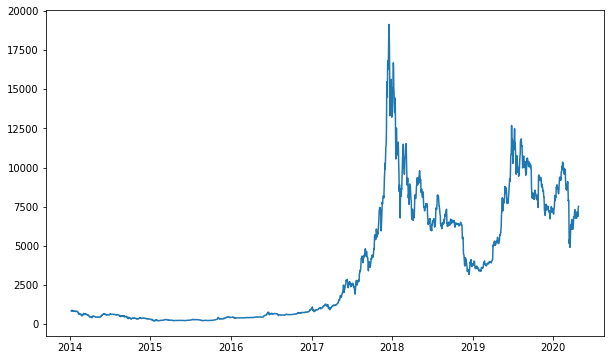

In [21]:
# Lets plot price again with filled values
plt.figure(figsize=(10,6))
plt.plot(data['Weighted Price'])
plt.show()

Clearly, few anaomolies are eliminated and the curve is smoother now.
Since, the feature 'Weighted Price' is to be fed into LSTM model, let's normalize using MinMaxScaler between the range of 0 and 1

In [28]:
values = data['Weighted Price'].values.reshape(-1,1)
values # We took all the values in the feature column and reshaped them into a 2d array of multiple rows and 1 column. (n x 1)

array([[ 841.8355223 ],
       [ 839.15626937],
       [ 831.57291257],
       ...,
       [7029.51868596],
       [7413.92204172],
       [7516.23431701]])

In [29]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

Splitting the data into 70% for training and 30% for testing

In [30]:
train_size = int(len(values) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[:train_size,:], scaled[train_size:,:]
print(len(train), len(test))

1610 690


In [31]:
#Creating a function for creating dataset with look_back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [32]:
#generating trainX, trainY, testX, testY
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

1609
689


In [34]:
#reshaping dataset for feeding into the model
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Running LSTM with 100 epochs

In [39]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), dropout=0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=50, validation_data=(testX, testY), verbose=0, shuffle=False)

### Plot line graph to show amount loss according the the epoch

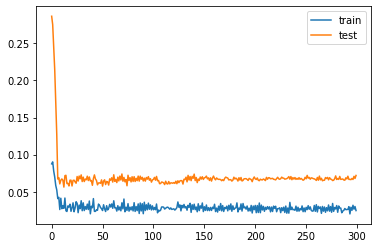

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

The heavy volatility after 2017 made the model loss not to converge below 0.05.

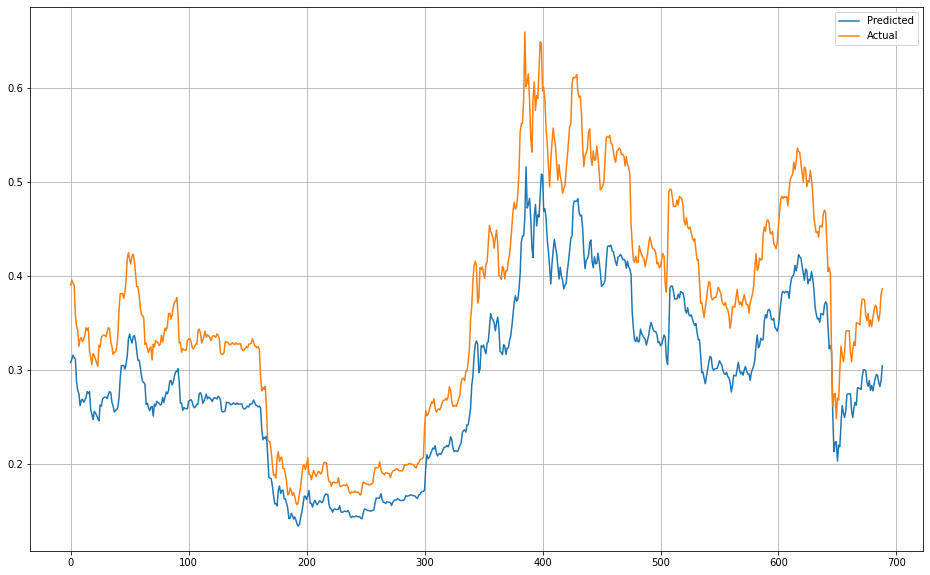

In [44]:
plt.figure(figsize=(16,10))
yhat = model.predict(testX)
plt.plot(yhat, label='Predicted')
plt.plot(testY, label='Actual')
plt.legend()
plt.grid(True)
plt.show()

Sclaing back using inverse transform

In [45]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [46]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: {}'.format(rmse))

Test RMSE: 1477.151834742504


RMSE of this magnitude is huge for the price. Doing a basic EDA with help findout relationship within data